# Introduction
This Recommender System recommends similar hostels with an explanation and as a result, such recommendations become more effective and more persuasive.

Since there is no data available for hostels in Ireland on data libraries so I have scrapped the data from Hostel World website for the experiment.

Let's start by importing the necessary libraries.

In [12]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import euclidean_distances

import warnings
warnings.filterwarnings('ignore') 

In [13]:
# Loading and displaying the dataset
df_hostels = pd.read_csv("../input/hybrid.csv", encoding='latin1')

df_hostels.head()

,hostel.id,summary.score,rating.band,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,...,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Name,Distance,City,Price
0,1,9.1,Superb,9.0,9.6,9.1,9.1,8.6,9.3,8.9,...,0,0,0,0,0,1,Jacobs Inn,0.6km from city centre,Dublin,19.05
1,2,8.7,Fabulous,8.3,8.9,9.7,8.9,8.2,8.2,8.3,...,0,1,1,1,1,1,Abbey Court,0.4km from city centre,Dublin,12.49
2,3,7.9,Very Good,7.6,8.2,8.7,8.3,7.8,7.6,7.4,...,0,0,1,1,1,0,Isaacs Hostel,0.5km from city centre,Dublin,12.00
3,4,8.0,Fabulous,7.7,8.6,9.0,8.5,7.3,7.3,7.3,...,0,0,0,0,0,0,Abrahams Hostel,0.4km from city centre,Dublin,11.00
4,5,7.8,Very Good,7.2,8.1,9.3,8.1,7.3,7.5,7.2,...,0,0,1,1,1,0,Kinlay House Dublin,1km from city centre,Dublin,12.00


Here for some entertainment features, the values are give as 1 and 0. It means 0 = No and 1 = Yes.

# 1. Exploratory Data Analysis

In [14]:
# General Information
df_hostels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 21 columns):
hostel.id          120 non-null int64
summary.score      120 non-null float64
rating.band        120 non-null object
Value.for.money    120 non-null float64
Security           120 non-null float64
Location           120 non-null float64
Staff              120 non-null float64
Atmosphere         120 non-null float64
Cleanliness        120 non-null float64
Facilities         120 non-null float64
Board.Games        120 non-null int64
Dvds               120 non-null int64
Foosball           120 non-null int64
Games.Room         120 non-null int64
PlayStation        120 non-null int64
Pool.Table         120 non-null int64
Wifi               120 non-null int64
Name               120 non-null object
Distance           120 non-null object
City               120 non-null object
Price              120 non-null float64
dtypes: float64(9), int64(8), object(4)
memory usage: 19.8+ KB


In [15]:
# Statistical characteristics of numerical features
df_hostels.describe()

,hostel.id,summary.score,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Price
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.0,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000
mean,60.500000,7.495833,6.915833,7.243333,7.510833,7.390833,6.890000,7.021667,6.695833,0.416667,0.0,0.050000,0.116667,0.033333,0.17500,0.475000,25.106083
std,34.785054,3.140048,3.474517,3.493204,3.587485,3.568513,3.445796,3.472029,3.390035,0.495074,0.0,0.218859,0.322369,0.180258,0.38156,0.501468,18.694775
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,9.590000
25%,30.750000,7.575000,6.275000,7.275000,8.000000,7.775000,6.625000,6.525000,5.975000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,15.000000
50%,60.500000,8.700000,8.400000,8.800000,9.100000,8.900000,8.150000,8.300000,8.050000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,19.425000
75%,90.250000,9.400000,9.200000,9.425000,9.700000,9.625000,9.300000,9.500000,8.925000,1.000000,0.0,0.000000,0.000000,0.000000,0.00000,1.000000,30.000000
max,120.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.00000,1.000000,174.750000


Let's draw histograms for some relavent fields:

Text(0.5, 1.0, 'summary.score')

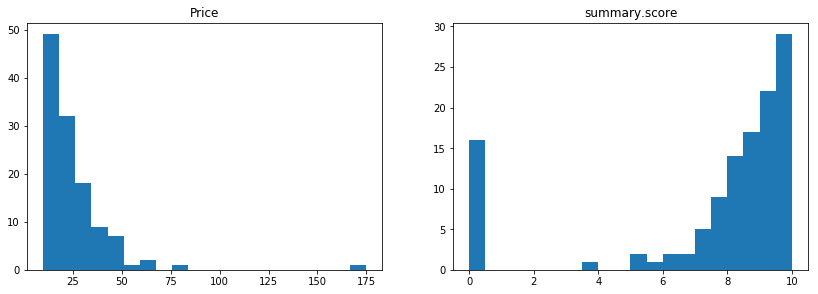

In [16]:
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.hist(df_hostels['Price'].values, bins=20)
plt.title('Price')
plt.subplot(222)
plt.hist(df_hostels['summary.score'].values, bins=20)
plt.title('summary.score')

Most hostels in the dataset are between 10 to 50 Euros.

# 2. Data Preprocessing
Handling Missing Values

In [17]:
df_hostels.isnull().sum()

hostel.id          0
summary.score      0
rating.band        0
Value.for.money    0
Security           0
Location           0
Staff              0
Atmosphere         0
Cleanliness        0
Facilities         0
Board.Games        0
Dvds               0
Foosball           0
Games.Room         0
PlayStation        0
Pool.Table         0
Wifi               0
Name               0
Distance           0
City               0
Price              0
dtype: int64

No missing value are found.

Now, I'm deleting summary.score, name, and rating.band columns because summary.score is giving the average value for columns like value.for.money, security, location, staff, atmosphere, cleanliness, and facilities. But since we are taking these features separately for similarity computation so we have removed the summary.score column. We can access the name later so name column is removed. The third column rating.band is also not necessary and is removed because it is giving rating based on summary.score i-e if summary.score is between 1 to 3, then rating.band is "Good".

In [18]:
df_hostels.drop(['summary.score', 'Name', 'rating.band'], inplace=True, axis=1);

In [19]:
# Label Encoding
le = LabelEncoder()
df_hostels['Distance'] = le.fit_transform(df_hostels['Distance'])
df_hostels['City'] = le.fit_transform(df_hostels['City'])

df_hostels.head(3)

,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price
0,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05
1,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49
2,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.00


# 3. Modeling

In [20]:
# Function get all cities
def getSameCityRows(anchor_id):
    getRow = df_hostels.loc[anchor_id-1, :]
    city = getRow['City']
    df_sorted = df_hostels.loc[df_hostels['City'] == int(city)]
    return df_sorted

def get_recommendations(df, anchor_id):
    featureString = 'Distance,Price,City'
    getRow = df.loc[anchor_id-1, :]
    
    if(getRow['Value.for.money'] != 0.0):
        featureString+=",Value.for.money"
    if(getRow['Security'] != 0.0):
        featureString+=",Security"
    if(getRow['Location'] != 0.0):
        featureString+=",Location"
    if(getRow['Staff'] != 0.0):
        featureString+=",Staff"
    if(getRow['Atmosphere'] != 0.0):
        featureString+=",Atmosphere"
    if(getRow['Cleanliness'] != 0.0):
        featureString+=",Cleanliness"
    if(getRow['Facilities'] != 0.0):
        featureString+=",Facilities"
        
    if(getRow['Board.Games'] != 0):
        featureString+=",Board.Games"
    if(getRow['Dvds'] != 0):
        featureString+=",Dvds"
    if(getRow['Foosball'] != 0):
        featureString+=",Foosball"
    if(getRow['Games.Room'] != 0):
        featureString+=",Games.Room"
    if(getRow['PlayStation'] != 0):
        featureString+=",PlayStation"
    if(getRow['Pool.Table'] != 0):
        featureString+=",Pool.Table"
    if(getRow['Wifi'] != 0):
        featureString+=",Wifi"
    
    features = featureString.split(',')
    
    df_sorted = df.copy()
    df_sorted = pd.concat([df_sorted[df_sorted['hostel.id'] == anchor_id],df_sorted[df_sorted['hostel.id'] != anchor_id]])
    df_features = df_sorted[features].copy()
    df_features = normalize_features(df_features)
    
    # compute the distances
    X = df_features.values
    Y = df_features.values[0].reshape(1, -1)
    distances = euclidean_distances(X, Y)
    df_sorted['similarity_distance'] = distances
    return df_sorted.sort_values('similarity_distance').reset_index(drop=True)
    
def normalize_features(df):
    for col in df.columns:
        # fill any NaN's with the mean
        df[col] = df[col].fillna(df[col].mean())
        df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))
    return df

def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list    

# 4. Explainable Processing Methods

Now, I will code to put an explanation before the hostels' recommendations according to this logic.

If all three recommended hostels have 8 or more than 8 rating in any of the following columns (Value.for.money, Security, Location, Staff, Atmosphere, Cleanliness, Facilities), then mention those in the explanation.

Also, If all three recommended hostels have 1 which means yes in any of the following columns (Board.Games, Dvds, Foosball, Games.Room, PlayStation, Pool.Table or Wifi), then mention those in the explanation.

In [21]:
def processSummary(df):
    tf = (df.values > 7.9)
    if False in tf[:]:
        return False
    else:
        return True
def processEntertainment(df):
    tf = (df.values == 1)
    if False in tf[:]:
        return False
    else:
        return True
def getExplaination(finalShowDown):
    # Summary Fields
    value_for_money = processSummary(finalShowDown['Value.for.money'])
    security = processSummary(finalShowDown['Security'])
    staff = processSummary(finalShowDown['Staff'])
    atmosphere = processSummary(finalShowDown['Atmosphere'])
    clean = processSummary(finalShowDown['Cleanliness'])
    facilities = processSummary(finalShowDown['Facilities'])
    location = processSummary(finalShowDown['Location'])
    
    summary = ""
    finalDecision = "Similar hostels "
    if(value_for_money):
        summary+='Value for money, '
    if(security):
        summary+='Security, '
    if(staff):
        summary+='Staff, '
    if(atmosphere):
        summary+='Atmosphere, '
    if(clean):
        summary+='Cleanliness, '
    if(facilities):
        summary+='Facilities, '
    if(location):
        summary+='Location, '

    if summary != "":
        summary = removeLastOccurence(summary, ",")
        summary_split = summary.split(",")
        if(len(summary_split) > 1):
            summary = removeAgainOccurence(summary, ",")
        finalDecision+="who are famous for excellent "+summary
        
    # Entertainment Fields
    board_games = processEntertainment(finalShowDown['Board.Games'])
    dvd = processEntertainment(finalShowDown['Dvds'])
    foosball = processEntertainment(finalShowDown['Foosball'])
    games_room = processEntertainment(finalShowDown['Games.Room'])
    play_station = processEntertainment(finalShowDown['PlayStation'])
    pool_table = processEntertainment(finalShowDown['Pool.Table'])
    wifi = processEntertainment(finalShowDown['Wifi'])
    
    entertainment = ""
    if(board_games):
        entertainment+='Board Games, '
    if(dvd):
        entertainment+='DVDs, '
    if(foosball):
        entertainment+='Foosball, '
    if(games_room):
        entertainment+='Games Room, '
    if(play_station):
        entertainment+='PlayStation, '
    if(pool_table):
        entertainment+='Pool Table, '
    if(wifi):
        entertainment+='Wifi, '

    if entertainment != "":
        entertainment = removeLastOccurence(entertainment, ",")
        ent_split = entertainment.split(",")
        if(len(ent_split) > 1):
            entertainment = removeAgainOccurence(entertainment, ",")
        if summary != "":
            finalDecision+="and also have "+entertainment+"."
        else:
            finalDecision+="who have "+entertainment+"."
    else:
        finalDecision+="."
    return removeLastOccurence(finalDecision, " ")

def removeLastOccurence(str_val, delimiter):
    k = str_val.rfind(delimiter)
    new_string = str_val[:k] + "" + str_val[k+1:]
    return new_string
def removeAgainOccurence(str_val, delimiter):
    k = str_val.rfind(delimiter)
    new_string = str_val[:k] + " and" + str_val[k+1:]
    return new_string

Results for all hostel ids using loop

In [22]:
for anchor_id in range(1,121):
    getRows = getSameCityRows(anchor_id)

    recommendations = get_recommendations(getRows, anchor_id)

    finalShowDown = recommendations.head(n=4)

    print("\n") 
    print('\033[1m'+"Test Resuts for hostel.id="+str(anchor_id)+"\n")
    explaination = getExplaination(finalShowDown) 
    if(explaination == 'Similar hostels.'):
        explaination = 'Similar hostels which have similar Price and have same Distance from the City Centre.' 
    print(explaination)

    display(finalShowDown)




Test Resuts for hostel.id=1

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05,0.000000
1,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.00,0.319763
2,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,0.426986
3,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.583878




Test Resuts for hostel.id=2

Similar hostels who are famous for excellent Security, Staff and Location and also have Games Room and Pool Table.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.000000
1,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,4.149088
2,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.00,4.157995
3,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,4.642671




Test Resuts for hostel.id=3

Similar hostels who are famous for excellent Security, Staff and Location and also have Board Games, Games Room and Pool Table.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.00,0.000000
1,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.541887
2,5,7.2,8.1,9.3,8.1,7.3,7.5,7.2,1,0,0,1,1,1,0,25,4,12.00,2.008594
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,4.146516




Test Resuts for hostel.id=4

Similar hostels who are famous for excellent Security, Staff and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,4,7.7,8.6,9.0,8.5,7.3,7.3,7.3,1,0,0,0,0,0,0,3,4,11.0,2.980232e-08
1,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.0,2.470746e-01
2,11,8.1,8.8,9.7,8.7,7.8,7.9,7.9,1,0,0,0,0,0,1,5,4,12.0,4.129650e-01
3,6,8.3,9.0,9.8,8.6,7.9,8.0,8.1,1,0,0,0,0,0,0,4,4,13.0,4.735503e-01




Test Resuts for hostel.id=5

Similar hostels who are famous for excellent Security, Staff and Location and also have Board Games, Games Room and Pool Table.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,5,7.2,8.1,9.3,8.1,7.3,7.5,7.2,1,0,0,1,1,1,0,25,4,12.00,0.000000
1,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.00,2.008594
2,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,2.183197
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,4.412194




Test Resuts for hostel.id=6

Similar hostels who are famous for excellent Value for money, Security, Staff and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,6,8.3,9.0,9.8,8.6,7.9,8.0,8.1,1,0,0,0,0,0,0,4,4,13.00,0.000000
1,11,8.1,8.8,9.7,8.7,7.8,7.9,7.9,1,0,0,0,0,0,1,5,4,12.00,0.151907
2,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.177396
3,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.00,0.455629




Test Resuts for hostel.id=7

Similar hostels who are famous for excellent Value for money, Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,7,8.5,9.0,9.7,9.3,8.2,8.1,8.3,0,0,0,0,0,0,0,5,4,13.00,2.980232e-08
1,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,2.304608e-01
2,6,8.3,9.0,9.8,8.6,7.9,8.0,8.1,1,0,0,0,0,0,0,4,4,13.00,2.473709e-01
3,11,8.1,8.8,9.7,8.7,7.8,7.9,7.9,1,0,0,0,0,0,1,5,4,12.00,2.721340e-01




Test Resuts for hostel.id=8

Similar hostels who are famous for excellent Security, Staff, Atmosphere, Facilities and Location and also have Games Room, Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,0.000000
1,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,0.604560
2,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.766643
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,3.597192




Test Resuts for hostel.id=9

Similar hostels who are famous for excellent Value for money, Security, Staff and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.00,0.000000
1,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05,0.319763
2,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.363858
3,11,8.1,8.8,9.7,8.7,7.8,7.9,7.9,1,0,0,0,0,0,1,5,4,12.00,0.561988




Test Resuts for hostel.id=10

Similar hostels who are famous for excellent Security, Staff, Atmosphere, Facilities and Location and also have Games Room, Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,0.000000
1,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.692882
2,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,2.144130
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,3.609485




Test Resuts for hostel.id=11

Similar hostels who are famous for excellent Value for money, Security, Staff and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,11,8.1,8.8,9.7,8.7,7.8,7.9,7.9,1,0,0,0,0,0,1,5,4,12.00,0.000000
1,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.277446
2,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,0.500122
3,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.00,0.561988




Test Resuts for hostel.id=12

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Facilities and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,12,8.7,9.1,9.2,9.2,8.4,9.2,8.8,1,0,0,0,0,0,1,14,4,12.0,0.000000
1,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.0,0.604628
2,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.0,0.604807
3,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.0,0.777136




Test Resuts for hostel.id=13

Similar hostels who are famous for excellent Security, Staff and Location and also have Foosball and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.00,5.960464e-08
1,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,8.262763e-01
2,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,8.803981e-01
3,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,2.158240e+00




Test Resuts for hostel.id=14

Similar hostels who are famous for excellent Security, Staff, Atmosphere, Facilities and Location and also have Games Room, Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,0.000000
1,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,0.430533
2,2,8.3,8.9,9.7,8.9,8.2,8.2,8.3,1,0,1,1,1,1,1,3,4,12.49,0.622790
3,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,2.080521




Test Resuts for hostel.id=15

Similar hostels who are famous for excellent Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,15,7.8,8.2,9.4,8.3,7.7,6.8,7.3,0,0,0,0,0,0,0,5,4,15.0,0.000000
1,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.0,0.334945
2,4,7.7,8.6,9.0,8.5,7.3,7.3,7.3,1,0,0,0,0,0,0,3,4,11.0,0.344635
3,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.0,0.427831




Test Resuts for hostel.id=16

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,16,6.3,7.2,8.4,7.9,5.9,6.3,5.1,0,0,0,0,0,0,0,4,4,15.00,0.000000
1,30,6.2,7.4,8.4,7.6,6.4,6.7,5.9,0,0,0,0,0,0,0,3,4,12.00,0.345335
2,19,5.9,6.3,9.0,6.9,5.2,4.8,4.9,0,0,0,0,0,0,0,7,4,16.38,0.691755
3,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.00,0.959029




Test Resuts for hostel.id=17

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Facilities and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.0,0.000000
1,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.0,0.537620
2,12,8.7,9.1,9.2,9.2,8.4,9.2,8.8,1,0,0,0,0,0,1,14,4,12.0,0.604807
3,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.0,0.648954




Test Resuts for hostel.id=18

Similar hostels who are famous for excellent Value for money, Security, Staff, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,18,8.8,8.8,8.7,9.5,9.0,9.5,8.7,0,0,0,0,0,0,0,7,4,40.00,0.000000
1,29,8.3,9.1,8.8,8.9,7.6,8.4,7.7,0,0,0,0,0,0,0,6,4,34.00,0.674617
2,42,10.0,10.0,9.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,5,4,34.12,0.760347
3,23,8.5,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,1,5,4,49.50,0.814000




Test Resuts for hostel.id=19

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,19,5.9,6.3,9.0,6.9,5.2,4.8,4.9,0,0,0,0,0,0,0,7,4,16.38,0.000000
1,16,6.3,7.2,8.4,7.9,5.9,6.3,5.1,0,0,0,0,0,0,0,4,4,15.00,0.691755
2,30,6.2,7.4,8.4,7.6,6.4,6.7,5.9,0,0,0,0,0,0,0,3,4,12.00,0.904349
3,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.00,1.413513




Test Resuts for hostel.id=20

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere and Cleanliness.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,20,9.0,8.8,9.5,8.8,8.8,8.3,7.5,0,0,0,0,0,0,0,17,4,31.0,0.000000
1,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.0,0.772298
2,12,8.7,9.1,9.2,9.2,8.4,9.2,8.8,1,0,0,0,0,0,1,14,4,12.0,0.919921
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.0,1.041136




Test Resuts for hostel.id=21

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Facilities and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,21,9.3,10.0,8.5,10.0,10.0,10.0,9.9,1,0,0,0,0,0,0,14,4,47.00,0.000000
1,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.00,1.415092
2,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05,1.493285
3,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,1.502785




Test Resuts for hostel.id=22

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,22,10.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,0,0,5,4,21.50,0.000000
1,42,10.0,10.0,9.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,5,4,34.12,0.614042
2,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05,0.699802
3,26,8.8,10.0,10.0,9.6,9.2,10.0,8.8,0,0,0,0,0,0,0,2,4,27.00,0.710574




Test Resuts for hostel.id=23

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,23,8.5,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,1,5,4,49.50,0.000000
1,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05,1.331105
2,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.00,1.484454
3,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,1.522939




Test Resuts for hostel.id=24

Similar hostels who are famous for excellent Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,24,7.5,7.3,8.3,8.5,7.5,8.0,7.3,0,0,0,0,0,0,0,3,4,21.0,0.000000
1,3,7.6,8.2,8.7,8.3,7.8,7.6,7.4,1,0,0,1,1,1,0,4,4,12.0,0.469879
2,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.0,0.473445
3,4,7.7,8.6,9.0,8.5,7.3,7.3,7.3,1,0,0,0,0,0,0,3,4,11.0,0.590385




Test Resuts for hostel.id=25

Similar hostels who have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,25,7.0,6.7,8.3,7.7,6.3,8.0,7.0,1,0,0,0,0,0,0,26,4,17.50,0.000000
1,5,7.2,8.1,9.3,8.1,7.3,7.5,7.2,1,0,0,1,1,1,0,25,4,12.00,0.624600
2,27,8.0,8.0,8.0,8.0,7.0,8.0,6.0,1,0,0,0,0,0,1,37,4,28.75,1.270087
3,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.00,1.594804




Test Resuts for hostel.id=26

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,26,8.8,10.0,10.0,9.6,9.2,10.0,8.8,0,0,0,0,0,0,0,2,4,27.00,4.214685e-08
1,1,9.0,9.6,9.1,9.1,8.6,9.3,8.9,1,0,0,0,0,0,1,5,4,19.05,5.760053e-01
2,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.00,6.189985e-01
3,22,10.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,0,0,5,4,21.50,7.105741e-01




Test Resuts for hostel.id=27

Similar hostels who have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,27,8.0,8.0,8.0,8.0,7.0,8.0,6.0,1,0,0,0,0,0,1,37,4,28.75,0.000000
1,25,7.0,6.7,8.3,7.7,6.3,8.0,7.0,1,0,0,0,0,0,0,26,4,17.50,2.401120
2,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.00,2.426292
3,5,7.2,8.1,9.3,8.1,7.3,7.5,7.2,1,0,0,1,1,1,0,25,4,12.00,2.483836




Test Resuts for hostel.id=28

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,28,8.7,8.0,8.0,8.7,7.3,9.0,8.3,0,0,0,0,0,0,0,34,4,24.00,0.000000
1,27,8.0,8.0,8.0,8.0,7.0,8.0,6.0,1,0,0,0,0,0,1,37,4,28.75,0.848671
2,25,7.0,6.7,8.3,7.7,6.3,8.0,7.0,1,0,0,0,0,0,0,26,4,17.50,1.174781
3,5,7.2,8.1,9.3,8.1,7.3,7.5,7.2,1,0,0,1,1,1,0,25,4,12.00,1.242340




Test Resuts for hostel.id=29

Similar hostels who are famous for excellent Security and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,29,8.3,9.1,8.8,8.9,7.6,8.4,7.7,0,0,0,0,0,0,0,6,4,34.0,0.000000
1,18,8.8,8.8,8.7,9.5,9.0,9.5,8.7,0,0,0,0,0,0,0,7,4,40.0,0.674617
2,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.0,0.745469
3,33,7.3,8.7,8.7,6.7,7.3,8.7,7.3,0,0,0,0,0,0,1,3,4,34.0,0.751700




Test Resuts for hostel.id=30

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,30,6.2,7.4,8.4,7.6,6.4,6.7,5.9,0,0,0,0,0,0,0,3,4,12.0,0.000000
1,16,6.3,7.2,8.4,7.9,5.9,6.3,5.1,0,0,0,0,0,0,0,4,4,15.0,0.345335
2,4,7.7,8.6,9.0,8.5,7.3,7.3,7.3,1,0,0,0,0,0,0,3,4,11.0,0.798095
3,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.0,0.814060




Test Resuts for hostel.id=31

Similar hostels who are famous for excellent Value for money, Security, Staff, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,31,9.3,10.0,10.0,8.7,8.0,8.0,8.7,0,0,0,0,0,0,0,3,4,60.0,0.000000
1,23,8.5,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,1,5,4,49.5,1.075536
2,18,8.8,8.8,8.7,9.5,9.0,9.5,8.7,0,0,0,0,0,0,0,7,4,40.0,1.126566
3,29,8.3,9.1,8.8,8.9,7.6,8.4,7.7,0,0,0,0,0,0,0,6,4,34.0,1.183396




Test Resuts for hostel.id=32

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,3,4,43.52,0.000000
1,23,8.5,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,1,5,4,49.50,0.294770
2,33,7.3,8.7,8.7,6.7,7.3,8.7,7.3,0,0,0,0,0,0,1,3,4,34.00,0.359182
3,18,8.8,8.8,8.7,9.5,9.0,9.5,8.7,0,0,0,0,0,0,0,7,4,40.00,0.401966




Test Resuts for hostel.id=33

Similar hostels who are famous for excellent Security and Location and also have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,33,7.3,8.7,8.7,6.7,7.3,8.7,7.3,0,0,0,0,0,0,1,3,4,34.0,0.000000
1,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.0,0.874011
2,11,8.1,8.8,9.7,8.7,7.8,7.9,7.9,1,0,0,0,0,0,1,5,4,12.0,1.117991
3,9,8.7,9.2,9.6,8.8,8.5,9.2,8.6,1,0,0,0,0,0,1,3,4,16.0,1.143136




Test Resuts for hostel.id=34

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,16,4,44.50,0.000000
1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,16,4,40.25,0.160349
2,21,9.3,10.0,8.5,10.0,10.0,10.0,9.9,1,0,0,0,0,0,0,14,4,47.00,0.211853
3,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,16,4,38.50,0.226375




Test Resuts for hostel.id=35

Similar hostels who have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,16,4,38.50,2.107342e-08
1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,16,4,40.25,6.602609e-02
2,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.00,7.189647e-01
3,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,26,4,35.75,9.541413e-01




Test Resuts for hostel.id=36

Similar hostels who have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,30,4,26.67,0.000000
1,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,26,4,35.75,0.511176
2,27,8.0,8.0,8.0,8.0,7.0,8.0,6.0,1,0,0,0,0,0,1,37,4,28.75,0.668560
3,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,16,4,38.50,1.400883




Test Resuts for hostel.id=37

Similar hostels who have Games Room, Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,16,4,40.25,0.000000
1,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,1.161197
2,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,1.165225
3,10,8.6,9.1,8.0,9.3,8.2,9.0,8.7,1,0,1,1,0,1,1,7,4,18.00,1.197251




Test Resuts for hostel.id=38

Similar hostels who have Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,26,4,35.75,0.000000
1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,16,4,40.25,0.963559
2,8,7.8,8.9,8.5,8.6,8.2,7.8,8.1,0,0,1,1,0,1,1,10,4,13.30,1.737950
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,1.792430




Test Resuts for hostel.id=39

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,39,2.0,7.0,8.0,8.0,3.0,5.0,3.0,0,0,0,0,0,0,0,4,4,26.34,0.000000
1,19,5.9,6.3,9.0,6.9,5.2,4.8,4.9,0,0,0,0,0,0,0,7,4,16.38,1.534920
2,16,6.3,7.2,8.4,7.9,5.9,6.3,5.1,0,0,0,0,0,0,0,4,4,15.00,1.699717
3,30,6.2,7.4,8.4,7.6,6.4,6.7,5.9,0,0,0,0,0,0,0,3,4,12.00,1.910064




Test Resuts for hostel.id=40

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,40,4.0,10.0,4.0,6.0,8.0,8.0,6.0,0,0,0,0,0,0,0,5,4,25.0,0.000000
1,33,7.3,8.7,8.7,6.7,7.3,8.7,7.3,0,0,0,0,0,0,1,3,4,34.0,1.731241
2,30,6.2,7.4,8.4,7.6,6.4,6.7,5.9,0,0,0,0,0,0,0,3,4,12.0,1.758891
3,13,7.3,8.3,8.3,8.4,7.4,7.1,7.3,1,0,1,0,0,0,1,6,4,21.0,1.766029




Test Resuts for hostel.id=41

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,41,10.0,9.0,10.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,0,12,4,55.0,0.000000
1,21,9.3,10.0,8.5,10.0,10.0,10.0,9.9,1,0,0,0,0,0,0,14,4,47.0,0.685867
2,23,8.5,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,1,5,4,49.5,0.908091
3,18,8.8,8.8,8.7,9.5,9.0,9.5,8.7,0,0,0,0,0,0,0,7,4,40.0,0.955897




Test Resuts for hostel.id=42

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,42,10.0,10.0,9.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,5,4,34.12,4.214685e-08
1,22,10.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,0,0,0,0,5,4,21.50,6.140424e-01
2,26,8.8,10.0,10.0,9.6,9.2,10.0,8.8,0,0,0,0,0,0,0,2,4,27.00,7.258118e-01
3,18,8.8,8.8,8.7,9.5,9.0,9.5,8.7,0,0,0,0,0,0,0,7,4,40.00,7.603472e-01




Test Resuts for hostel.id=43

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,43,8.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,0,28,4,63.0,0.000000
1,21,9.3,10.0,8.5,10.0,10.0,10.0,9.9,1,0,0,0,0,0,0,14,4,47.0,1.557246
2,41,10.0,9.0,10.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,0,12,4,55.0,1.670177
3,20,9.0,8.8,9.5,8.8,8.8,8.3,7.5,0,0,0,0,0,0,0,17,4,31.0,1.814071




Test Resuts for hostel.id=44

Similar hostels who have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,15,4,17.85,0.000000
1,17,8.1,8.9,7.9,9.0,8.2,8.6,8.0,1,0,0,0,0,0,1,13,4,21.00,0.223851
2,12,8.7,9.1,9.2,9.2,8.4,9.2,8.8,1,0,0,0,0,0,1,14,4,12.00,0.240233
3,14,8.4,8.7,8.9,9.1,8.1,8.3,8.2,1,0,0,1,0,1,1,9,4,15.00,0.579159




Test Resuts for hostel.id=45

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,5,4,174.75,0.000000
1,23,8.5,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,1,5,4,49.50,4.725581
2,31,9.3,10.0,10.0,8.7,8.0,8.0,8.7,0,0,0,0,0,0,0,3,4,60.00,4.788753
3,41,10.0,9.0,10.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,0,12,4,55.00,5.000603




Test Resuts for hostel.id=46

Similar hostels who have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,47,4,83.75,0.000000
1,27,8.0,8.0,8.0,8.0,7.0,8.0,6.0,1,0,0,0,0,0,1,37,4,28.75,2.281597
2,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,30,4,26.67,3.386683
3,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,26,4,35.75,3.388046




Test Resuts for hostel.id=47

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,3,4,30.56,0.000000
1,33,7.3,8.7,8.7,6.7,7.3,8.7,7.3,0,0,0,0,0,0,1,3,4,34.00,0.129788
2,26,8.8,10.0,10.0,9.6,9.2,10.0,8.8,0,0,0,0,0,0,0,2,4,27.00,0.164429
3,39,2.0,7.0,8.0,8.0,3.0,5.0,3.0,0,0,0,0,0,0,0,4,4,26.34,0.185328




Test Resuts for hostel.id=48

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.0,0.000000
1,52,8.6,9.0,9.5,9.4,8.6,8.2,8.3,1,0,0,0,0,0,1,4,5,13.0,0.276440
2,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.0,0.290344
3,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,0.357265




Test Resuts for hostel.id=49

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,0.000000
1,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,0.698162
2,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.0,0.767916
3,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.0,2.388834




Test Resuts for hostel.id=50

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,50,8.7,9.2,9.4,9.2,8.6,8.9,8.7,1,0,0,0,0,0,1,4,5,9.59,4.214685e-08
1,52,8.6,9.0,9.5,9.4,8.6,8.2,8.3,1,0,0,0,0,0,1,4,5,13.00,4.486394e-01
2,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.00,6.473870e-01
3,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.00,7.049211e-01




Test Resuts for hostel.id=51

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.0,0.000000
1,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,0.111394
2,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.0,0.620252
3,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,0.694887




Test Resuts for hostel.id=52

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,52,8.6,9.0,9.5,9.4,8.6,8.2,8.3,1,0,0,0,0,0,1,4,5,13.00,0.000000
1,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.00,0.276440
2,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.00,0.370434
3,50,8.7,9.2,9.4,9.2,8.6,8.9,8.7,1,0,0,0,0,0,1,4,5,9.59,0.448639




Test Resuts for hostel.id=53

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.0,0.000000
1,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,4.814777
2,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,5.978069
3,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.0,6.397346




Test Resuts for hostel.id=54

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Facilities and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,0.000000
1,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.0,4.814777
2,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,5.969510
3,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.0,6.400732




Test Resuts for hostel.id=55

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,55,9.4,9.7,8.8,9.8,9.6,9.7,9.6,0,0,0,0,0,0,1,16,5,20.0,0.000000
1,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.0,0.976532
2,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,1.033155
3,48,8.8,9.2,9.8,9.4,8.7,8.5,8.5,1,0,0,0,0,0,1,3,5,15.0,1.179671




Test Resuts for hostel.id=56

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,56,7.1,6.6,9.0,7.8,6.7,5.5,6.3,0,0,0,0,0,0,0,5,5,12.00,0.000000
1,58,6.2,7.7,9.1,7.9,6.4,8.0,6.5,0,0,0,0,0,0,0,0,5,17.04,0.984924
2,52,8.6,9.0,9.5,9.4,8.6,8.2,8.3,1,0,0,0,0,0,1,4,5,13.00,1.265954
3,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.00,1.271687




Test Resuts for hostel.id=57

Similar hostels who are famous for excellent Security and Staff.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,57,9.1,9.0,9.2,9.8,9.3,9.3,8.9,0,0,0,0,0,0,0,39,5,20.0,0.000000
1,60,10.0,9.5,10.0,10.0,10.0,9.5,10.0,0,0,0,0,0,0,0,33,5,19.8,0.611304
2,62,7.4,8.8,7.9,9.3,7.3,7.1,7.9,0,0,0,0,0,1,1,27,5,26.5,1.451100
3,61,8.0,10.0,10.0,9.0,9.0,10.0,9.0,0,0,0,0,0,0,0,27,5,30.0,1.486523




Test Resuts for hostel.id=58

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,58,6.2,7.7,9.1,7.9,6.4,8.0,6.5,0,0,0,0,0,0,0,0,5,17.04,0.000000
1,56,7.1,6.6,9.0,7.8,6.7,5.5,6.3,0,0,0,0,0,0,0,5,5,12.00,0.984924
2,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.00,0.990636
3,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.00,1.037265




Test Resuts for hostel.id=59

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,59,10.0,8.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,6,5,39.50,0.000000
1,61,8.0,10.0,10.0,9.0,9.0,10.0,9.0,0,0,0,0,0,0,0,27,5,30.00,1.953374
2,63,8.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,4,5,21.25,2.226272
3,55,9.4,9.7,8.8,9.8,9.6,9.7,9.6,0,0,0,0,0,0,1,16,5,20.00,2.409762




Test Resuts for hostel.id=60

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,60,10.0,9.5,10.0,10.0,10.0,9.5,10.0,0,0,0,0,0,0,0,33,5,19.8,0.000000
1,57,9.1,9.0,9.2,9.8,9.3,9.3,8.9,0,0,0,0,0,0,0,39,5,20.0,0.611304
2,55,9.4,9.7,8.8,9.8,9.6,9.7,9.6,0,0,0,0,0,0,1,16,5,20.0,1.181056
3,61,8.0,10.0,10.0,9.0,9.0,10.0,9.0,0,0,0,0,0,0,0,27,5,30.0,1.420970




Test Resuts for hostel.id=61

Similar hostels who are famous for excellent Security and Staff.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,61,8.0,10.0,10.0,9.0,9.0,10.0,9.0,0,0,0,0,0,0,0,27,5,30.0,0.000000
1,62,7.4,8.8,7.9,9.3,7.3,7.1,7.9,0,0,0,0,0,1,1,27,5,26.5,1.141156
2,60,10.0,9.5,10.0,10.0,10.0,9.5,10.0,0,0,0,0,0,0,0,33,5,19.8,1.420970
3,55,9.4,9.7,8.8,9.8,9.6,9.7,9.6,0,0,0,0,0,0,1,16,5,20.0,1.470551




Test Resuts for hostel.id=62

Similar hostels who are famous for excellent Security and Staff and also have Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,62,7.4,8.8,7.9,9.3,7.3,7.1,7.9,0,0,0,0,0,1,1,27,5,26.5,0.000000
1,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,2.000391
2,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,2.221551
3,53,8.5,9.1,9.7,8.4,8.4,8.1,8.5,1,0,1,1,0,1,1,2,5,15.0,2.228300




Test Resuts for hostel.id=63

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,63,8.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,4,5,21.25,4.214685e-08
1,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.00,5.315926e-01
2,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.00,5.728040e-01
3,55,9.4,9.7,8.8,9.8,9.6,9.7,9.6,0,0,0,0,0,0,1,16,5,20.00,9.447008e-01




Test Resuts for hostel.id=64

Similar hostels who have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,3,5,22.5,0.000000
1,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.0,0.409297
2,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,0.425015
3,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,0.634734




Test Resuts for hostel.id=65

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,36,5,35.0,0.000000
1,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,40,5,30.0,0.634747
2,61,8.0,10.0,10.0,9.0,9.0,10.0,9.0,0,0,0,0,0,0,0,27,5,30.0,0.828873
3,62,7.4,8.8,7.9,9.3,7.3,7.1,7.9,0,0,0,0,0,1,1,27,5,26.5,1.147316




Test Resuts for hostel.id=66

Similar hostels who have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,40,5,30.0,0.000000
1,62,7.4,8.8,7.9,9.3,7.3,7.1,7.9,0,0,0,0,0,1,1,27,5,26.5,2.285457
2,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,26,5,24.0,2.378582
3,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.0,2.814879




Test Resuts for hostel.id=67

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,44,5,44.5,0.000000
1,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,36,5,35.0,1.217275
2,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,40,5,30.0,1.694158
3,61,8.0,10.0,10.0,9.0,9.0,10.0,9.0,0,0,0,0,0,0,0,27,5,30.0,2.015814




Test Resuts for hostel.id=68

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6,5,25.00,0.000000
1,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,3,5,22.50,0.350117
2,63,8.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,4,5,21.25,0.452523
3,51,9.3,9.7,9.9,9.6,9.5,9.5,9.2,1,0,0,0,0,0,1,2,5,19.00,0.741221




Test Resuts for hostel.id=69

Similar hostels who have Pool Table and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,26,5,24.0,0.000000
1,62,7.4,8.8,7.9,9.3,7.3,7.1,7.9,0,0,0,0,0,1,1,27,5,26.5,0.295994
2,54,8.3,9.0,9.2,9.3,8.5,7.9,8.1,1,0,0,1,1,1,1,3,5,17.0,1.721909
3,49,9.4,9.6,9.8,9.7,9.3,9.4,9.4,1,0,0,0,0,1,1,1,5,19.0,1.750702




Test Resuts for hostel.id=70

Similar hostels who are famous for excellent Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,70,8.0,8.5,9.1,8.9,8.0,8.1,7.7,1,0,0,0,0,1,1,4,0,18.33,4.214685e-08
1,71,8.2,8.3,8.9,8.9,7.8,8.3,8.1,0,0,0,0,0,0,1,4,0,16.00,2.965986e+00
2,72,7.6,8.1,8.4,8.6,7.2,7.2,7.4,1,0,0,0,0,0,0,4,0,16.00,3.156056e+00
3,75,10.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,1,10,0,25.50,4.172302e+00




Test Resuts for hostel.id=71

Similar hostels who are famous for excellent Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,71,8.2,8.3,8.9,8.9,7.8,8.3,8.1,0,0,0,0,0,0,1,4,0,16.00,2.980232e-08
1,70,8.0,8.5,9.1,8.9,8.0,8.1,7.7,1,0,0,0,0,1,1,4,0,18.33,5.450454e-01
2,72,7.6,8.1,8.4,8.6,7.2,7.2,7.4,1,0,0,0,0,0,0,4,0,16.00,2.307223e+00
3,75,10.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,1,10,0,25.50,3.164707e+00




Test Resuts for hostel.id=72

Similar hostels who are famous for excellent Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,72,7.6,8.1,8.4,8.6,7.2,7.2,7.4,1,0,0,0,0,0,0,4,0,16.00,0.000000
1,70,8.0,8.5,9.1,8.9,8.0,8.1,7.7,1,0,0,0,0,1,1,4,0,18.33,0.980148
2,71,8.2,8.3,8.9,8.9,7.8,8.3,8.1,0,0,0,0,0,0,1,4,0,16.00,2.196196
3,75,10.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,1,10,0,25.50,4.190747




Test Resuts for hostel.id=73

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,73,4.0,4.0,5.0,3.0,3.0,5.0,3.0,1,0,0,0,0,1,0,10,0,20.00,8.429370e-08
1,74,3.0,6.0,9.0,5.0,4.0,6.0,4.0,0,0,0,0,0,0,1,2,0,30.00,5.389986e+00
2,72,7.6,8.1,8.4,8.6,7.2,7.2,7.4,1,0,0,0,0,0,0,4,0,16.00,5.955553e+00
3,70,8.0,8.5,9.1,8.9,8.0,8.1,7.7,1,0,0,0,0,1,1,4,0,18.33,6.221441e+00




Test Resuts for hostel.id=74

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,74,3.0,6.0,9.0,5.0,4.0,6.0,4.0,0,0,0,0,0,0,1,2,0,30.00,0.000000
1,70,8.0,8.5,9.1,8.9,8.0,8.1,7.7,1,0,0,0,0,1,1,4,0,18.33,4.611764
2,72,7.6,8.1,8.4,8.6,7.2,7.2,7.4,1,0,0,0,0,0,0,4,0,16.00,4.904563
3,71,8.2,8.3,8.9,8.9,7.8,8.3,8.1,0,0,0,0,0,0,1,4,0,16.00,4.923855




Test Resuts for hostel.id=75

Similar hostels who are famous for excellent Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,75,10.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0,0,0,0,0,1,10,0,25.50,0.000000
1,70,8.0,8.5,9.1,8.9,8.0,8.1,7.7,1,0,0,0,0,1,1,4,0,18.33,2.984644
2,71,8.2,8.3,8.9,8.9,7.8,8.3,8.1,0,0,0,0,0,0,1,4,0,16.00,3.164707
3,72,7.6,8.1,8.4,8.6,7.2,7.2,7.4,1,0,0,0,0,0,0,4,0,16.00,4.249983




Test Resuts for hostel.id=76

Similar hostels who are famous for excellent Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,76,8.8,9.0,9.7,9.4,8.5,8.5,8.3,1,0,0,1,0,0,0,9,7,14.00,0.000000
1,81,9.2,9.5,9.0,9.6,9.3,9.0,8.6,1,0,0,1,0,0,1,38,7,12.75,2.342759
2,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.50,2.953934
3,77,7.6,7.5,9.1,7.7,7.0,6.6,6.9,1,0,0,0,0,0,0,13,7,10.00,2.983792




Test Resuts for hostel.id=77

Similar hostels who are famous for excellent Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,77,7.6,7.5,9.1,7.7,7.0,6.6,6.9,1,0,0,0,0,0,0,13,7,10.0,0.000000
1,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.0,0.537716
2,76,8.8,9.0,9.7,9.4,8.5,8.5,8.3,1,0,0,1,0,0,0,9,7,14.0,1.105078
3,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.0,1.116633




Test Resuts for hostel.id=78

Similar hostels who are famous for excellent Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.0,2.980232e-08
1,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.0,1.386920e+00
2,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.5,2.042111e+00
3,77,7.6,7.5,9.1,7.7,7.0,6.6,6.9,1,0,0,0,0,0,0,13,7,10.0,2.076764e+00




Test Resuts for hostel.id=79

Similar hostels who are famous for excellent Staff and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.00,5.960464e-08
1,81,9.2,9.5,9.0,9.6,9.3,9.0,8.6,1,0,0,1,0,0,1,38,7,12.75,1.288050e+00
2,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.00,1.386920e+00
3,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.50,2.053307e+00




Test Resuts for hostel.id=80

Similar hostels who are famous for excellent Staff and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.5,4.214685e-08
1,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.0,2.042111e+00
2,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.0,2.053307e+00
3,83,10.0,10.0,10.0,10.0,9.0,9.0,9.0,1,0,0,0,0,0,0,7,7,30.0,2.106969e+00




Test Resuts for hostel.id=81

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,81,9.2,9.5,9.0,9.6,9.3,9.0,8.6,1,0,0,1,0,0,1,38,7,12.75,0.000000
1,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.00,3.056287
2,76,8.8,9.0,9.7,9.4,8.5,8.5,8.3,1,0,0,1,0,0,0,9,7,14.00,3.084206
3,85,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,0,0,0,1,46,7,32.50,3.328241




Test Resuts for hostel.id=82

Similar hostels who are famous for excellent Staff and also have Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,82,8.8,8.0,7.2,8.4,7.6,8.0,8.8,0,0,0,0,0,0,1,29,7,14.00,0.000000
1,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.00,0.824356
2,81,9.2,9.5,9.0,9.6,9.3,9.0,8.6,1,0,0,1,0,0,1,38,7,12.75,1.122504
3,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.00,1.891657




Test Resuts for hostel.id=83

Similar hostels who are famous for excellent Staff and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,83,10.0,10.0,10.0,10.0,9.0,9.0,9.0,1,0,0,0,0,0,0,7,7,30.0,4.214685e-08
1,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.5,6.445985e-01
2,76,8.8,9.0,9.7,9.4,8.5,8.5,8.3,1,0,0,1,0,0,0,9,7,14.0,1.414656e+00
3,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.0,2.180367e+00




Test Resuts for hostel.id=84

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,9,7,32.5,0.000000
1,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.5,3.825158
2,78,7.2,7.7,9.5,8.5,7.1,6.1,5.6,1,0,0,0,0,0,1,11,7,13.0,4.080908
3,83,10.0,10.0,10.0,10.0,9.0,9.0,9.0,1,0,0,0,0,0,0,7,7,30.0,4.263146




Test Resuts for hostel.id=85

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere and Location and also have Board Games and Wifi.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,85,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,0,0,0,1,46,7,32.50,5.960464e-08
1,81,9.2,9.5,9.0,9.6,9.3,9.0,8.6,1,0,0,1,0,0,1,38,7,12.75,1.842652e+00
2,79,8.3,8.3,9.4,8.6,8.1,7.7,7.5,1,0,0,0,0,0,1,25,7,10.00,2.794012e+00
3,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.50,3.125013e+00




Test Resuts for hostel.id=86

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,86,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,9,7,40.0,5.960464e-08
1,83,10.0,10.0,10.0,10.0,9.0,9.0,9.0,1,0,0,0,0,0,0,7,7,30.0,9.529790e-01
2,80,9.7,9.6,9.8,9.8,9.7,9.7,9.7,1,0,0,0,0,0,1,8,7,23.5,1.367312e+00
3,76,8.8,9.0,9.7,9.4,8.5,8.5,8.3,1,0,0,1,0,0,0,9,7,14.0,2.289590e+00




Test Resuts for hostel.id=87

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6,7,39.50,0.000000
1,86,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,9,7,40.00,0.242704
2,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,9,7,32.50,0.620639
3,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,14,7,44.67,0.765429




Test Resuts for hostel.id=88

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,14,7,44.67,0.000000
1,86,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,9,7,40.00,0.552220
2,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6,7,39.50,0.765429
3,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,9,7,32.50,1.072511




Test Resuts for hostel.id=89

Similar hostels who are famous for excellent Value for money, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,0.000000
1,94,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,0,1,1,1,1,17.00,2.114202
2,91,8.5,8.6,9.1,8.3,7.5,7.9,7.3,1,0,0,0,0,0,0,3,1,16.00,2.317129
3,90,9.0,7.9,9.5,9.1,8.7,8.3,8.5,0,0,0,0,0,0,0,0,1,18.82,2.977797




Test Resuts for hostel.id=90

Similar hostels who are famous for excellent Value for money, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,90,9.0,7.9,9.5,9.1,8.7,8.3,8.5,0,0,0,0,0,0,0,0,1,18.82,0.000000
1,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,0.715899
2,91,8.5,8.6,9.1,8.3,7.5,7.9,7.3,1,0,0,0,0,0,0,3,1,16.00,0.758718
3,92,8.8,9.5,8.7,9.5,7.8,9.6,8.2,0,0,0,0,0,0,0,4,1,13.20,1.024881




Test Resuts for hostel.id=91

Similar hostels who are famous for excellent Value for money, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,91,8.5,8.6,9.1,8.3,7.5,7.9,7.3,1,0,0,0,0,0,0,3,1,16.00,0.000000
1,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,1.155749
2,90,9.0,7.9,9.5,9.1,8.7,8.3,8.5,0,0,0,0,0,0,0,0,1,18.82,2.212935
3,92,8.8,9.5,8.7,9.5,7.8,9.6,8.2,0,0,0,0,0,0,0,4,1,13.20,2.216493




Test Resuts for hostel.id=92

Similar hostels who are famous for excellent Value for money, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,92,8.8,9.5,8.7,9.5,7.8,9.6,8.2,0,0,0,0,0,0,0,4,1,13.20,0.000000
1,91,8.5,8.6,9.1,8.3,7.5,7.9,7.3,1,0,0,0,0,0,0,3,1,16.00,0.769034
2,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,0.925548
3,90,9.0,7.9,9.5,9.1,8.7,8.3,8.5,0,0,0,0,0,0,0,0,1,18.82,1.024881




Test Resuts for hostel.id=93

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,93,9.0,9.2,9.8,10.0,9.6,8.6,8.0,0,0,0,0,0,0,1,24,1,18.0,0.000000
1,96,9.3,8.7,8.7,9.3,9.3,8.7,9.3,1,0,0,1,0,1,0,22,1,14.0,2.139572
2,94,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,0,1,1,1,1,17.0,2.712229
3,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.0,2.753824




Test Resuts for hostel.id=94

Similar hostels who are famous for excellent Value for money, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,94,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,0,1,1,1,1,17.00,5.960464e-08
1,96,9.3,8.7,8.7,9.3,9.3,8.7,9.3,1,0,0,1,0,1,0,22,1,14.00,3.207018e+00
2,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,3.451421e+00
3,90,9.0,7.9,9.5,9.1,8.7,8.3,8.5,0,0,0,0,0,0,0,0,1,18.82,4.112714e+00




Test Resuts for hostel.id=95

Similar hostels who are famous for excellent Staff.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,95,6.0,6.0,6.0,8.0,6.0,4.0,4.0,0,0,0,0,0,1,0,19,1,10.0,0.000000
1,96,9.3,8.7,8.7,9.3,9.3,8.7,9.3,1,0,0,1,0,1,0,22,1,14.0,2.704044
2,91,8.5,8.6,9.1,8.3,7.5,7.9,7.3,1,0,0,0,0,0,0,3,1,16.0,3.566964
3,93,9.0,9.2,9.8,10.0,9.6,8.6,8.0,0,0,0,0,0,0,1,24,1,18.0,3.606065




Test Resuts for hostel.id=96

Similar hostels who are famous for excellent Value for money, Security, Staff and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,96,9.3,8.7,8.7,9.3,9.3,8.7,9.3,1,0,0,1,0,1,0,22,1,14.0,0.000000
1,94,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,0,1,1,1,1,17.0,3.251624
2,93,9.0,9.2,9.8,10.0,9.6,8.6,8.0,0,0,0,0,0,0,1,24,1,18.0,4.077960
3,91,8.5,8.6,9.1,8.3,7.5,7.9,7.3,1,0,0,0,0,0,0,3,1,16.0,4.143875




Test Resuts for hostel.id=97

Similar hostels who are famous for excellent Value for money, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,97,10.0,8.0,10.0,10.0,10.0,10.0,8.0,0,0,0,0,0,0,0,7,1,33.00,0.000000
1,90,9.0,7.9,9.5,9.1,8.7,8.3,8.5,0,0,0,0,0,0,0,0,1,18.82,1.876708
2,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,1.994353
3,94,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,0,1,1,1,1,17.00,2.036305




Test Resuts for hostel.id=98

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,18,1,26.25,0.000000
1,89,9.5,9.3,9.9,9.7,9.5,9.7,9.3,1,0,0,0,0,0,1,0,1,17.00,2.262937
2,93,9.0,9.2,9.8,10.0,9.6,8.6,8.0,0,0,0,0,0,0,1,24,1,18.00,2.362381
3,96,9.3,8.7,8.7,9.3,9.3,8.7,9.3,1,0,0,1,0,1,0,22,1,14.00,2.450669




Test Resuts for hostel.id=99

Similar hostels which have similar Price and have same Distance from the City Centre.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,7,1,42.50,0.000000
1,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,18,1,26.25,2.156203
2,97,10.0,8.0,10.0,10.0,10.0,10.0,8.0,0,0,0,0,0,0,0,7,1,33.00,2.257757
3,94,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1,0,1,1,1,1,17.00,2.850256




Test Resuts for hostel.id=100

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,100,8.5,8.9,9.5,9.0,8.3,8.3,8.3,1,0,0,0,0,0,0,23,9,17.0,0.000000
1,101,8.8,9.0,9.0,8.5,8.3,9.0,8.5,0,0,1,0,0,1,0,32,9,18.0,3.257577
2,102,9.8,9.6,9.8,10.0,9.8,10.0,9.2,1,0,0,0,0,0,1,21,9,17.0,4.539812
3,103,9.0,10.0,10.0,10.0,10.0,8.5,7.5,0,0,0,0,0,0,0,31,9,16.0,4.710995




Test Resuts for hostel.id=101

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,101,8.8,9.0,9.0,8.5,8.3,9.0,8.5,0,0,1,0,0,1,0,32,9,18.0,8.429370e-08
1,100,8.5,8.9,9.5,9.0,8.3,8.3,8.3,1,0,0,0,0,0,0,23,9,17.0,4.352602e+00
2,103,9.0,10.0,10.0,10.0,10.0,8.5,7.5,0,0,0,0,0,0,0,31,9,16.0,6.012340e+00
3,102,9.8,9.6,9.8,10.0,9.8,10.0,9.2,1,0,0,0,0,0,1,21,9,17.0,6.114776e+00




Test Resuts for hostel.id=102

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,102,9.8,9.6,9.8,10.0,9.8,10.0,9.2,1,0,0,0,0,0,1,21,9,17.00,0.000000
1,103,9.0,10.0,10.0,10.0,10.0,8.5,7.5,0,0,0,0,0,0,0,31,9,16.00,5.011759
2,104,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,35,9,44.75,5.037215
3,100,8.5,8.9,9.5,9.0,8.3,8.3,8.3,1,0,0,0,0,0,0,23,9,17.00,5.182653




Test Resuts for hostel.id=103

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,103,9.0,10.0,10.0,10.0,10.0,8.5,7.5,0,0,0,0,0,0,0,31,9,16.00,0.000000
1,102,9.8,9.6,9.8,10.0,9.8,10.0,9.2,1,0,0,0,0,0,1,21,9,17.00,3.834197
2,100,8.5,8.9,9.5,9.0,8.3,8.3,8.3,1,0,0,0,0,0,0,23,9,17.00,4.245799
3,104,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,35,9,44.75,4.819597




Test Resuts for hostel.id=104

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,104,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,0,0,0,35,9,44.75,5.960464e-08
1,102,9.8,9.6,9.8,10.0,9.8,10.0,9.2,1,0,0,0,0,0,1,21,9,17.00,3.867411e+00
2,103,9.0,10.0,10.0,10.0,10.0,8.5,7.5,0,0,0,0,0,0,0,31,9,16.00,4.819597e+00
3,101,8.8,9.0,9.0,8.5,8.3,9.0,8.5,0,0,1,0,0,1,0,32,9,18.00,6.083165e+00




Test Resuts for hostel.id=105

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,105,9.1,9.5,9.4,8.9,8.6,9.0,9.0,0,0,0,0,0,0,0,3,8,20.0,0.000000
1,106,8.4,9.2,9.6,9.6,9.6,9.2,8.0,0,0,0,0,0,0,0,22,8,24.0,2.327033
2,109,10.0,10.0,9.3,10.0,8.0,10.0,10.0,1,0,0,0,0,0,1,20,8,16.0,2.353721
3,107,8.3,8.1,9.1,8.8,8.1,8.0,7.6,1,0,0,0,0,0,1,45,8,17.5,3.590486




Test Resuts for hostel.id=106

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,106,8.4,9.2,9.6,9.6,9.6,9.2,8.0,0,0,0,0,0,0,0,22,8,24.0,0.000000
1,105,9.1,9.5,9.4,8.9,8.6,9.0,9.0,0,0,0,0,0,0,0,3,8,20.0,2.327033
2,107,8.3,8.1,9.1,8.8,8.1,8.0,7.6,1,0,0,0,0,0,1,45,8,17.5,3.402985
3,109,10.0,10.0,9.3,10.0,8.0,10.0,10.0,1,0,0,0,0,0,1,20,8,16.0,3.451472




Test Resuts for hostel.id=107

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,107,8.3,8.1,9.1,8.8,8.1,8.0,7.6,1,0,0,0,0,0,1,45,8,17.5,5.960464e-08
1,109,10.0,10.0,9.3,10.0,8.0,10.0,10.0,1,0,0,0,0,0,1,20,8,16.0,3.568808e+00
2,106,8.4,9.2,9.6,9.6,9.6,9.2,8.0,0,0,0,0,0,0,0,22,8,24.0,4.462470e+00
3,105,9.1,9.5,9.4,8.9,8.6,9.0,9.0,0,0,0,0,0,0,0,3,8,20.0,4.607051e+00




Test Resuts for hostel.id=108

Similar hostels who are famous for excellent Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,108,5.3,6.7,8.0,6.7,6.7,6.0,5.3,1,0,0,0,0,0,1,11,8,25.0,0.000000
1,107,8.3,8.1,9.1,8.8,8.1,8.0,7.6,1,0,0,0,0,0,1,45,8,17.5,5.384114
2,105,9.1,9.5,9.4,8.9,8.6,9.0,9.0,0,0,0,0,0,0,0,3,8,20.0,6.805759
3,106,8.4,9.2,9.6,9.6,9.6,9.2,8.0,0,0,0,0,0,0,0,22,8,24.0,7.052728




Test Resuts for hostel.id=109

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,109,10.0,10.0,9.3,10.0,8.0,10.0,10.0,1,0,0,0,0,0,1,20,8,16.0,0.000000
1,107,8.3,8.1,9.1,8.8,8.1,8.0,7.6,1,0,0,0,0,0,1,45,8,17.5,3.568808
2,105,9.1,9.5,9.4,8.9,8.6,9.0,9.0,0,0,0,0,0,0,0,3,8,20.0,3.724693
3,106,8.4,9.2,9.6,9.6,9.6,9.2,8.0,0,0,0,0,0,0,0,22,8,24.0,4.499554




Test Resuts for hostel.id=110

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,110,8.6,8.5,9.3,8.7,8.0,7.8,7.9,1,0,0,1,0,1,1,3,6,15.0,0.00000
1,112,9.3,9.1,9.6,9.6,8.6,9.3,8.4,0,0,0,0,0,0,1,2,6,17.0,7.07243
2,111,9.2,8.9,9.7,9.4,8.9,8.9,8.6,0,0,0,0,0,0,0,1,6,15.0,7.32231




Test Resuts for hostel.id=111

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,111,9.2,8.9,9.7,9.4,8.9,8.9,8.6,0,0,0,0,0,0,0,1,6,15.0,0.000000
1,112,9.3,9.1,9.6,9.6,8.6,9.3,8.4,0,0,0,0,0,0,1,2,6,17.0,2.977332
2,110,8.6,8.5,9.3,8.7,8.0,7.8,7.9,1,0,0,1,0,1,1,3,6,15.0,5.967933




Test Resuts for hostel.id=112

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,112,9.3,9.1,9.6,9.6,8.6,9.3,8.4,0,0,0,0,0,0,1,2,6,17.0,0.000000
1,111,9.2,8.9,9.7,9.4,8.9,8.9,8.6,0,0,0,0,0,0,0,1,6,15.0,3.655750
2,110,8.6,8.5,9.3,8.7,8.0,7.8,7.9,1,0,0,1,0,1,1,3,6,15.0,6.043118




Test Resuts for hostel.id=113

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,113,9.6,9.1,9.8,9.6,9.6,9.6,9.5,1,0,0,0,0,0,1,0,3,18.0,0.000000
1,114,9.4,9.3,9.2,9.5,9.3,9.3,8.9,1,0,0,0,0,0,0,6,3,21.0,6.324555




Test Resuts for hostel.id=114

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location and also have Board Games.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,114,9.4,9.3,9.2,9.5,9.3,9.3,8.9,1,0,0,0,0,0,0,6,3,21.0,0.0
1,113,9.6,9.1,9.8,9.6,9.6,9.6,9.5,1,0,0,0,0,0,1,0,3,18.0,6.0




Test Resuts for hostel.id=115

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,115,9.7,9.5,9.8,9.8,9.7,9.6,9.7,1,0,0,0,0,0,1,48,2,13.5,0.000000
1,118,9.4,9.7,9.4,10.0,9.4,9.7,9.4,0,0,0,0,0,0,1,42,2,10.0,3.099217
2,117,9.7,9.4,9.3,9.7,9.5,9.7,9.4,0,0,0,0,0,0,0,8,2,17.0,4.271642
3,116,10.0,10.0,10.0,10.0,10.0,10.0,9.7,0,0,0,0,0,0,0,41,2,18.0,4.283812




Test Resuts for hostel.id=116

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,116,10.0,10.0,10.0,10.0,10.0,10.0,9.7,0,0,0,0,0,0,0,41,2,18.0,0.000000
1,115,9.7,9.5,9.8,9.8,9.7,9.6,9.7,1,0,0,0,0,0,1,48,2,13.5,2.674145
2,118,9.4,9.7,9.4,10.0,9.4,9.7,9.4,0,0,0,0,0,0,1,42,2,10.0,3.119688
3,117,9.7,9.4,9.3,9.7,9.5,9.7,9.4,0,0,0,0,0,0,0,8,2,17.0,3.131879




Test Resuts for hostel.id=117

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,117,9.7,9.4,9.3,9.7,9.5,9.7,9.4,0,0,0,0,0,0,0,8,2,17.0,0.000000
1,115,9.7,9.5,9.8,9.8,9.7,9.6,9.7,1,0,0,0,0,0,1,48,2,13.5,2.654605
2,118,9.4,9.7,9.4,10.0,9.4,9.7,9.4,0,0,0,0,0,0,1,42,2,10.0,2.689497
3,116,10.0,10.0,10.0,10.0,10.0,10.0,9.7,0,0,0,0,0,0,0,41,2,18.0,3.131879




Test Resuts for hostel.id=118

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,118,9.4,9.7,9.4,10.0,9.4,9.7,9.4,0,0,0,0,0,0,1,42,2,10.0,4.214685e-08
1,115,9.7,9.5,9.8,9.8,9.7,9.6,9.7,1,0,0,0,0,0,1,48,2,13.5,1.550854e+00
2,117,9.7,9.4,9.3,9.7,9.5,9.7,9.4,0,0,0,0,0,0,0,8,2,17.0,3.351626e+00
3,116,10.0,10.0,10.0,10.0,10.0,10.0,9.7,0,0,0,0,0,0,0,41,2,18.0,3.705733e+00




Test Resuts for hostel.id=119

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,119,8.5,10.0,8.0,8.5,8.5,9.5,7.0,0,0,0,0,0,0,1,43,2,12.5,0.000000
1,118,9.4,9.7,9.4,10.0,9.4,9.7,9.4,0,0,0,0,0,0,1,42,2,10.0,5.086617
2,115,9.7,9.5,9.8,9.8,9.7,9.6,9.7,1,0,0,0,0,0,1,48,2,13.5,5.709043
3,117,9.7,9.4,9.3,9.7,9.5,9.7,9.4,0,0,0,0,0,0,0,8,2,17.0,5.927204




Test Resuts for hostel.id=120

Similar hostels who are famous for excellent Value for money, Security, Staff, Atmosphere, Cleanliness, Facilities and Location.


,hostel.id,Value.for.money,Security,Location,Staff,Atmosphere,Cleanliness,Facilities,Board.Games,Dvds,Foosball,Games.Room,PlayStation,Pool.Table,Wifi,Distance,City,Price,similarity_distance
0,120,9.0,8.0,10.0,10.0,9.0,10.0,8.0,0,0,0,0,0,0,0,6,2,23.75,0.000000
1,117,9.7,9.4,9.3,9.7,9.5,9.7,9.4,0,0,0,0,0,0,0,8,2,17.00,3.913075
2,116,10.0,10.0,10.0,10.0,10.0,10.0,9.7,0,0,0,0,0,0,0,41,2,18.00,5.039978
3,118,9.4,9.7,9.4,10.0,9.4,9.7,9.4,0,0,0,0,0,0,1,42,2,10.00,5.152377


The results look promising.